<a href="https://colab.research.google.com/github/SDS-AAU/DSBA-2022/blob/master/static/notebooks/M2_assignment_example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2. DSBA 2022 

---
## 1. NLP processing. Data augmentation: 

Use NLP techniques to create categories for the different positions (these are only free-text at the moment) and create a consistent industry column. Impute (predict) the education requirements for all jobs. You can use different strategies to create larger labels for the freetext, including (but not limitd to):

 + Hand labeling of several jobs, and use these to predict for the remaining labels.
 + Do a topic modeling on the job description, and label them with the topic most associated.
 + Do something else… (eg. cluster job descriptions by TFIDF-weighted DTM…)

In [2]:
import itertools
import numpy as np 
import pandas as pd
import tqdm
!pip install preprocessor
import preprocessor as prepro
import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import itertools
import random
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4477 sha256=13ef8528329c92486ab1f9eeb7b3ab5fb36dd2d361b69ddfeba15394ab6ea5dd
  Stored in directory: /root/.cache/pip/wheels/0e/b7/36/aa37256db62b4bfd35a6f1b5536e9ba843f257b79dcbf3d5f1
Successfully built preprocessor


In [3]:
!wget https://github.com/aaubs/ds-master/raw/main/data/Job_search.zip

--2022-11-11 14:59:24--  https://github.com/aaubs/ds-master/raw/main/data/Job_search.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aaubs/ds-master/main/data/Job_search.zip [following]
--2022-11-11 14:59:24--  https://raw.githubusercontent.com/aaubs/ds-master/main/data/Job_search.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6862703 (6.5M) [application/zip]
Saving to: ‘Job_search.zip’

Job_search.zip      100%[===================>]   6.54M  --.-KB/s    in 0.1s    

2022-11-11 14:59:25 (46.2 MB/s) - ‘Job_search.zip’ saved [6862703/6862703]



In [4]:
!unzip Job_search.zip

Archive:  Job_search.zip
   creating: Job_search/
  inflating: __MACOSX/._Job_search   
  inflating: Job_search/user_work_interest.csv  
  inflating: __MACOSX/Job_search/._user_work_interest.csv  
  inflating: Job_search/.DS_Store    
  inflating: __MACOSX/Job_search/._.DS_Store  
  inflating: Job_search/user_job_views.csv  
  inflating: __MACOSX/Job_search/._user_job_views.csv  
  inflating: Job_search/user_past_experience.csv  
  inflating: __MACOSX/Job_search/._user_past_experience.csv  
  inflating: Job_search/jobs.csv     
  inflating: __MACOSX/Job_search/._jobs.csv  


In [5]:
jobs=pd.read_csv('Job_search/jobs.csv')
applications=pd.read_csv('Job_search/user_job_views.csv')
interests=pd.read_csv('Job_search/user_work_interest.csv')

> There are different ways of doing the categories. I will choose the third way by clustering the jobs with a vectorizer. Also, we can work with jobs dataframe and/or applications and interests. In both of this we could categorize the jobs. First lets check the length of the dataframes

---
### 1.1. First analysis 

In [ ]:
print('The amount of different jobs are:',len(jobs))
print('The amount of different applications are:',len(applications))
print('The length of different interests of applicants0:',len(interests))

The amount of different jobs are: 84090
The amount of different applications are: 12370
The length of different interests of applicants0: 6560


> So we can check there is a lot of differences between these dataframes. Also something that seems interesting is the amount of jobs offered and how few applications there are. And assuming there are more than 1 person that applies to a job, then there are a lot of jobs with no applications. This makes me reconsider working with the jobs dataframe, since it would be doing work with a huge data, than it is not going to be useful later. Anyhow, lets check that all jobs inside applications are part of the jobs dataframe, that way if the analysis is done in the jobs dataframe this could be used later

In [ ]:
# For this I create a dataframe withe unique values of jobs in the dataframe of jobs. 
#I do the same for applications
unique_jobs_jobs=pd.DataFrame()
unique_jobs_jobs['Job.ID']=jobs['Job.ID'].unique()
unique_jobs_jobs=unique_jobs_jobs.sort_values(by=['Job.ID'], ascending=True)
unique_jobs_jobs

,Job.ID
66565,3
50456,28
66566,30
83985,33
83992,35
...,...
83978,319170
83979,319171
83980,319172
83981,319173


In [ ]:
unique_jobs_applications=pd.DataFrame()
unique_jobs_applications['Job.ID']=applications['Job.ID'].unique()
unique_jobs_applications=unique_jobs_applications.sort_values(by=['Job.ID'], 
                                                              ascending=True)
unique_jobs_applications

,Job.ID
3722,3
5509,30
7046,33
5142,35
7042,45
...,...
779,252998
5140,253757
5151,255393
5152,260689


In [ ]:
# Here the two dataframes are merged by job_id 
#and the length should be exactly 84090 (the lenght of jobs dataframe)
unique_jobs=pd.merge(unique_jobs_jobs,unique_jobs_applications, 
                     on='Job.ID', how='outer')
unique_jobs=unique_jobs.drop_duplicates()
unique_jobs

,Job.ID
0,3
1,28
2,30
3,33
4,35
...,...
90097,242146
90098,242309
90099,242634
90100,242735


> In this last dataframe there are 90.102 rows, which means there are 6.012 extra jobs that do not appear in the jobs dataframe. Taking in cosideration that in the applications dataframe there are only 7.047 unique jobs, only 1.035 out of the 84.090 are connected between these two dataframes. We could try to categorize the 84.000 values, but would it be worth it?

> Lets do the same check with users, and see that the ones at interests( the third dataframe) are the same as the ones at applicantions

In [ ]:
# First we create the two dataframes with applicant.ID and then merge it
unique_applicants_applications=pd.DataFrame()
unique_applicants_applications['Applicant.ID']=applications['Applicant.ID'].unique()
unique_applicants_applications=unique_applicants_applications.sort_values(by=['Applicant.ID'], 
                                                                          ascending=True)
unique_applicants_applications

,Applicant.ID
2508,42
3272,96
2468,153
2543,601
2469,1877
...,...
2463,14546
2464,14547
2465,14549
2466,14552


In [ ]:
unique_applicants_interest=pd.DataFrame()
unique_applicants_interest['Applicant.ID']=interests['Applicant.ID'].unique()
unique_applicants_interest=unique_applicants_interest.sort_values(by=['Applicant.ID'], 
                                                                  ascending=True)
unique_applicants_interest

,Applicant.ID
2027,96
381,153
626,256
1303,438
1534,568
...,...
376,14503
377,14514
378,14520
379,14522


In [ ]:
unique_applicants=pd.merge(unique_applicants_applications,
                           unique_applicants_interest, 
                           on='Applicant.ID', how='outer')
unique_applicants=unique_applicants.drop_duplicates()
unique_applicants

,Applicant.ID
0,42
1,96
2,153
3,601
4,1877
...,...
5011,14152
5012,14274
5013,14383
5014,14411


> So we can see there are more applicant id in the applications dataframes than in the interests one, which. This means that we should not use the interest dataframe to create the categories, which was my initial idea (as you can check on 1.2. my throughout analaysis). Skip 1.2 and go to 1.3 to check the real analysis and categorization
>
> ***Note: The above analyis was done thinking that part 1 and 2 where going to be connected. After doing the whole assignment, and realizing this was not true, I still decided to leave 1.3. as my main analysis since working with the jobs dataframe is very computationally demanding. But In 1.4., it is the categorization of jobs with this dataframe. It follows the same procedure as in 1.3.***

---
### 1.2. Categories by Interest 

In [ ]:
#First lets check that there are no null values

In [ ]:
jobs.head().T

,0,1,2,3,4
Job.ID,111,113,117,121,127
Provider,1,1,1,1,1
Status,open,open,open,open,open
Slug,palo-alto-ca-tacolicious-server,san-francisco-ca-claude-lane-kitchen-staff-chef,san-francisco-ca-machka-restaurants-corp-barte...,brisbane-ca-teriyaki-house-server,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...
Title,Server @ Tacolicious,Kitchen Staff/Chef @ Claude Lane,Bartender @ Machka Restaurants Corp.,Server @ Teriyaki House,Kitchen Staff/Chef @ Rosa Mexicano - Sunset
Position,Server,Kitchen Staff/Chef,Bartender,Server,Kitchen Staff/Chef
Company,Tacolicious,Claude Lane,Machka Restaurants Corp.,Teriyaki House,Rosa Mexicano - Sunset
City,Palo Alto,San Francisco,San Francisco,Brisbane,Los Angeles
State.Name,California,California,California,California,California
State.Code,CA,CA,CA,CA,CA


In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job.ID              84090 non-null  int64  
 1   Provider            84090 non-null  int64  
 2   Status              84090 non-null  object 
 3   Slug                84090 non-null  object 
 4   Title               84090 non-null  object 
 5   Position            84090 non-null  object 
 6   Company             81819 non-null  object 
 7   City                83955 non-null  object 
 8   State.Name          83919 non-null  object 
 9   State.Code          83919 non-null  object 
 10  Address             36 non-null     object 
 11  Latitude            84090 non-null  float64
 12  Longitude           84090 non-null  float64
 13  Industry            267 non-null    object 
 14  Requirements        0 non-null      float64
 15  Salary              229 non-null    float64
 16  List

In [ ]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6560 entries, 0 to 6559
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Applicant.ID          6560 non-null   int64 
 1   Position.Of.Interest  6558 non-null   object
 2   Created.At            6560 non-null   object
 3   Updated.At            6560 non-null   object
dtypes: int64(1), object(3)
memory usage: 205.1+ KB


In [ ]:
# There are 2 values that are null, so we should drop them, but in all dataframes
#ELIMINATE NULL VALUES OF POSITION OF INTERESTS

In [ ]:
applications['Job.ID'].value_counts()

221890    114
231297    103
48285      60
48200      46
153198     45
         ... 
63151       1
77942       1
132601      1
81118       1
33          1
Name: Job.ID, Length: 7047, dtype: int64

In [ ]:
 # no null values of applications regarding job.id, or application.id

> The way we will combine all databases is with applications, is the only one that connects jobs with users

In [ ]:
interests['Position.Of.Interest'].head().T

0    security officer
1              Server
2           Bartender
3                Host
4             Barista
Name: Position.Of.Interest, dtype: object

In [ ]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6560 entries, 0 to 6559
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Applicant.ID          6560 non-null   int64 
 1   Position.Of.Interest  6558 non-null   object
 2   Created.At            6560 non-null   object
 3   Updated.At            6560 non-null   object
dtypes: int64(1), object(3)
memory usage: 205.1+ KB


> If we do this, we have to make sure we are not applying a position category wrong. Maybe, some applicants apply to jobs of different positions that the ones they say they are looking for. We could combine this with the tokenization of position, lets see

In [ ]:
interests['Position.Of.Interest'].value_counts()

Customer Service Rep     1109
Receptionist             1070
Sales Rep                 555
Server                    531
Host                      524
                         ... 
Typist                      1
Library Assistant           1
office administrator        1
receptionist                1
securtiy                    1
Name: Position.Of.Interest, Length: 832, dtype: int64

> There are only 832 different values of categories in this column

In [ ]:
interests['Applicant.ID'].value_counts()

7101     13
3719     13
7528     13
2254     13
4965     11
         ..
5700      1
5703      1
2270      1
5767      1
10003     1
Name: Applicant.ID, Length: 2068, dtype: int64

>There are some applicants with more than 1 position of interest, so lets create a dataframe with unique applicantID and a column with the multiple positions of interest

In [ ]:
interests['Applicant.ID'].unique()

array([10003, 10007, 10008, ...,  9995,  9996,  9997], dtype=int64)

In [ ]:
interests['Applicant.ID'][3]

10008

In [ ]:
interests=interests.dropna()

In [ ]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6558 entries, 0 to 6559
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Applicant.ID          6558 non-null   int64 
 1   Position.Of.Interest  6558 non-null   object
 2   Created.At            6558 non-null   object
 3   Updated.At            6558 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.2+ KB


In [ ]:
interests['Position.Of.Interest'] = interests.groupby(['Applicant.ID'])['Position.Of.Interest'].transform(lambda x: ' '.join(x))
interests

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
0,10003,security officer,2014-12-12 21:20:54 UTC,2014-12-12 21:20:54 UTC
1,10007,Server Bartender,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
2,10007,Server Bartender,2014-08-14 15:56:44 UTC,2015-02-19 23:21:28 UTC
3,10008,Host Barista Receptionist Book Keeper Customer...,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
4,10008,Host Barista Receptionist Book Keeper Customer...,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
...,...,...,...,...
6555,9995,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
6556,9996,Security,2014-12-12 19:06:28 UTC,2014-12-12 19:06:28 UTC
6557,9997,Server Barista Bartender,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
6558,9997,Server Barista Bartender,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC


In [ ]:
interests=interests.drop(columns=['Created.At','Updated.At'])

In [ ]:
interests

,Applicant.ID,Position.Of.Interest
0,10003,security officer
1,10007,Server Bartender
2,10007,Server Bartender
3,10008,Host Barista Receptionist Book Keeper Customer...
4,10008,Host Barista Receptionist Book Keeper Customer...
...,...,...
6555,9995,Server
6556,9996,Security
6557,9997,Server Barista Bartender
6558,9997,Server Barista Bartender


In [ ]:
interests=interests.drop_duplicates()
# interests.reset_index

In [ ]:
interests

,Applicant.ID,Position.Of.Interest
0,10003,security officer
1,10007,Server Bartender
3,10008,Host Barista Receptionist Book Keeper Customer...
8,10012,Server
9,10016,Server Host
...,...,...
6545,9970,Server Host Receptionist Customer Service Rep ...
6550,9979,Receptionist Book Keeper Customer Service Rep ...
6555,9995,Server
6556,9996,Security


In [ ]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 6557
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Applicant.ID          2068 non-null   int64 
 1   Position.Of.Interest  2068 non-null   object
dtypes: int64(1), object(1)
memory usage: 48.5+ KB


> Now we have our dataframe of interests as we want it. With only one entrance for each applicant. Lets put this information on applications column

In [ ]:
jobs.head().T

,0,1,2,3,4
Job.ID,111,113,117,121,127
Provider,1,1,1,1,1
Status,open,open,open,open,open
Slug,palo-alto-ca-tacolicious-server,san-francisco-ca-claude-lane-kitchen-staff-chef,san-francisco-ca-machka-restaurants-corp-barte...,brisbane-ca-teriyaki-house-server,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...
Title,Server @ Tacolicious,Kitchen Staff/Chef @ Claude Lane,Bartender @ Machka Restaurants Corp.,Server @ Teriyaki House,Kitchen Staff/Chef @ Rosa Mexicano - Sunset
Position,Server,Kitchen Staff/Chef,Bartender,Server,Kitchen Staff/Chef
Company,Tacolicious,Claude Lane,Machka Restaurants Corp.,Teriyaki House,Rosa Mexicano - Sunset
City,Palo Alto,San Francisco,San Francisco,Brisbane,Los Angeles
State.Name,California,California,California,California,California
State.Code,CA,CA,CA,CA,CA


In [ ]:
jobs['Position'].unique

<bound method Series.unique of 0                    Server
1        Kitchen Staff/Chef
2                 Bartender
3                    Server
4        Kitchen Staff/Chef
                ...        
84085           Book Keeper
84086    Kitchen Staff/Chef
84087                Driver
84088             Line Cook
84089               Cashier
Name: Position, Length: 84090, dtype: object>

> Ok, wayyy bigger. Lets insert the column of interest in the jobs dataframe to be able to work with it

In [ ]:
applications['Applicant.ID'].value_counts()

601      75
6808     61
11475    56
6945     44
14136    43
         ..
3841      1
3803      1
10946     1
12846     1
13943     1
Name: Applicant.ID, Length: 3448, dtype: int64

In [ ]:
applications_merge=pd.merge(applications,interests,how='left', on='Applicant.ID')
applications_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12370 entries, 0 to 12369
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Applicant.ID          12370 non-null  int64  
 1   Job.ID                12370 non-null  int64  
 2   Title                 12370 non-null  object 
 3   Company               11790 non-null  object 
 4   City                  12370 non-null  object 
 5   State.Name            12348 non-null  object 
 6   State.Code            12348 non-null  object 
 7   Industry              2199 non-null   object 
 8   View.Start            12370 non-null  object 
 9   View.End              10575 non-null  object 
 10  View.Duration         10575 non-null  float64
 11  Created.At            12370 non-null  object 
 12  Updated.At            12370 non-null  object 
 13  Position.Of.Interest  2311 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.4+ MB


In [ ]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12370 entries, 0 to 12369
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Applicant.ID   12370 non-null  int64  
 1   Job.ID         12370 non-null  int64  
 2   Title          12370 non-null  object 
 3   Company        11790 non-null  object 
 4   City           12370 non-null  object 
 5   State.Name     12348 non-null  object 
 6   State.Code     12348 non-null  object 
 7   Industry       2199 non-null   object 
 8   View.Start     12370 non-null  object 
 9   View.End       10575 non-null  object 
 10  View.Duration  10575 non-null  float64
 11  Created.At     12370 non-null  object 
 12  Updated.At     12370 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 1.2+ MB


In [ ]:
print(len(applications_merge))
print(len(applications))

12370
12370


In [ ]:
applications_merge.head().T

,0,1,2,3,4
Applicant.ID,10000,10000,10001,10002,10002
Job.ID,73666,96655,84141,77989,69568
Title,Cashiers & Valets Needed! @ WallyPark,Macy's Seasonal Retail Fragrance Cashier - Ga...,Part Time Showroom Sales / Cashier @ Grizzly I...,Event Specialist Part Time @ Advantage Sales &...,Bonefish - Kitchen Staff @ Bonefish Grill
Company,WallyPark,Macy's,Grizzly Industrial Inc.,Advantage Sales & Marketing,Bonefish Grill
City,Newark,Garden City,Bellingham,Simpsonville,Greenville
State.Name,New Jersey,New York,Washington,South Carolina,South Carolina
State.Code,NJ,NY,WA,SC,SC
Industry,NaN,NaN,NaN,NaN,NaN
View.Start,2014-12-12 20:12:35 UTC,2014-12-12 20:08:50 UTC,2014-12-12 20:12:32 UTC,2014-12-12 20:39:23 UTC,2014-12-12 20:43:25 UTC
View.End,2014-12-12 20:31:24 UTC,2014-12-12 20:10:15 UTC,2014-12-12 20:17:18 UTC,2014-12-12 20:42:13 UTC,2014-12-12 20:43:58 UTC


> Now we have the information of categories for each application, depending on the Applicant information. But we need to put this information on the Job dataframe. We will not worry about words being duplicated inside the same job
>
> We will do the same steps as before. We will create a dataframe with the columns job id and position of interest, combine all values of possition of interests for the same jobid, and insert this into the dataframe jobs

In [ ]:
applicantions_help=applications_merge[['Job.ID','Position.Of.Interest']]
applicantions_help

,Job.ID,Position.Of.Interest
0,73666,NaN
1,96655,NaN
2,84141,NaN
3,77989,NaN
4,69568,NaN
...,...,...
12365,166,Server Barista Bartender
12366,531,Server Barista Bartender
12367,33,Server Barista Bartender
12368,517,Server Barista Bartender


In [ ]:
applicantions_help=applicantions_help.dropna()

In [ ]:
applicantions_help['Position.Of.Interest'] = applicantions_help.groupby(
    ['Job.ID'])['Position.Of.Interest'].transform(lambda x: ' '.join(x))
applicantions_help

,Job.ID,Position.Of.Interest
5,48200,security officer Receptionist Receptionist Una...
17,132416,Host Barista Receptionist Book Keeper Customer...
18,71544,Host Barista Receptionist Book Keeper Customer...
48,552,Server Host Server Server Host Server
49,49,Server Host Server Host Server Host Server Rec...
...,...,...
12358,64809,Security
12359,74245,Security
12360,85577,Security
12365,166,Server Barista Bartender


In [ ]:
applicantions_help=applicantions_help.drop_duplicates()

In [ ]:
len(applicantions_help)

1185

In [ ]:
len(jobs)

84090

> We see that there are only 1185 jobs that people with position of interest have applied. Taking in account that the number of jobs that people have applied to are:

In [ ]:
len(applications['Job.ID'].value_counts())

7047

> 7047
>
>So out of the 84090 jobs in the jobs dataframe only the 8% have been applied to. This means this method of assignning categories by interest does not seem very convinient, 

---
### 1.3. Creating categories from column Title. Clustering and vectorizer

> We will be using the applications dataframe and column ['Title']

In [ ]:
applications['Title'].value_counts()

Package Handler - Part-Time @ UPS                                             200
Driving Partner @ Uber                                                        190
Product Demonstrator - Costco                                                 152
Administrative Assistant @ OfficeTeam                                         152
CASHIER @ Murphy USA                                                          140
                                                                             ... 
Front Desk Coordinator - Must work 12/31 & 1/1 @ OfficeTeam                     1
**Up and coming Entertainment company seeks Payroll Clerk*** @ Accountemps      1
Cutting Edge Property Management Co Seeking Sr. Accountant @ Accountemps        1
Receptionist needed in Downtown San Diego! @ OfficeTeam                         1
Server @ Haven                                                                  1
Name: Title, Length: 4518, dtype: int64

> Out of the 7.047 unique job ids there are 4.518 that have unique Titles. Anyways, we are going to tokenize this column. So first of all lets clean it up a little bit, taking out the values as *, @ and afterwards, numbers, etc

In [ ]:
# We use this function that cleans our data and tokenize
def text_prepro(texts):
    """
    takes in a pandas series (1 column of a DF)
    removes twitter stuff
    lowercases, normalizes text
    """
    
    prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, 
                       prepro.OPT.RESERVED, prepro.OPT.MENTION, 
                       prepro.OPT.SMILEY)
    texts_clean = texts.str.split(pat='@', expand=True)[0]
    texts_clean = texts_clean.map(lambda t: prepro.clean(t))
    texts_clean = texts_clean.str.replace('#','')
    texts_clean = texts_clean.str.replace('Part-Time', '')
    texts_clean = texts_clean.str.replace('Part-time', '')
    texts_clean = texts_clean.str.replace('time', '')
    texts_clean = texts_clean.str.replace('\d+', '')
    
    clean_container = []

    pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

    for text in nlp.pipe(texts_clean):
        txt = [token.lemma_.lower() for token in text 
               if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV']
               and not token.like_num

               and not token.is_stop
               and not token.is_punct]
        clean_container.append(" ".join(txt))
        pbar.update(1)
        
    clean_container_2=[]
    pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)
    for text in nlp.pipe(clean_container):
        txt = [token.lemma_ for token in text ]
        clean_container_2.append(" ".join(txt))
        pbar.update(1)
        
        
#     #joining tokens into a string so as to have them together
#     string_tokens = []
#     cont = 0
#     for i in tokens:
#         var = ' '.join(tokens[cont])
#         string_tokens.append(var)
#         cont=cont+1
        
    return clean_container_2

In [ ]:
# We apply the procedure and create a new column 
applications['title_clean'] = text_prepro(applications['Title'])

C:\Users\USER\AppData\Local\Temp\ipykernel_20468\1512010652.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  texts_clean = texts_clean.str.replace('\d+', '')
100%|██████████████████████████████████████████████████████████████████████████| 12370/12370 [00:19<00:00, 1533.74it/s]

> There are no repetitions on jobs

In [ ]:
applications['title_clean']

0                                            cashier valet
1        macy seasonal retail fragrance cashier garden ...
2                               time showroom sale cashier
3                                    event specialist time
4                                   bonefish kitchen staff
                               ...                        
12365                                               server
12366                                               server
12367                                               server
12368                                               server
12369                                               server
Name: title_clean, Length: 12370, dtype: object

> Once we have the titles tokenize, we create the clusters. For that we create the dataframe vectorized

In [ ]:
# Change the name of the dataframe, for ease management
data=pd.DataFrame.copy(applications)

In [ ]:
# Create the dataframe that links each position with each word 
#with TfidVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()
X = vectorizer.fit_transform(data['title_clean'])

In [ ]:
pd.DataFrame(X.A, columns=vectorizer.get_feature_names())

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,academic,academy,accesorie,access,accommodation,account,accountant,accounting,accurate,...,xm,yankee,yard,year,yelm,yonker,york,youth,ypsilanti,yrs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> Lets do the elbow graph to check how many clusters would be necessary. But the amount of columns are too many, lets narrow it down for the analysis

In [ ]:
vectorizer_reduced= TfidfVectorizer(min_df=0.003)
X_reduced = vectorizer_reduced.fit_transform(data['title_clean'])
pd.DataFrame(X_reduced.A, columns=vectorizer_reduced.get_feature_names())

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,account,accountant,accounting,actor,admin,administrative,administrator,advisor,agent,aide,...,va,valet,valley,waiter,waitress,warehouse,washington,weekend,work,worker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.834953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> With 200 columns it will be easier to analyse the different alternatives, and retrive the best number of clusters

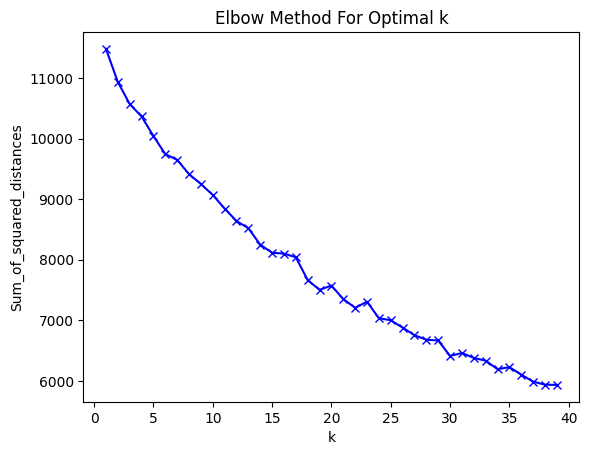

In [ ]:
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_reduced)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

> As it can be seen in this example the elbow method does not give much information. It does not seem to be an optimal number of clusters. Although from the graph, in this assignment we will use 30 categories

In [ ]:
clusterer = KMeans(n_clusters=30)

In [ ]:
clusterer.fit(X) # We use the initial vectorizer with all values

KMeans(n_clusters=30)

In [ ]:
#We include the cluster in a column inside the dataframe
data['cluster'] = clusterer.labels_ 

> Lets see how do the clusters work. We will do a test with a random cluster

In [ ]:
test=pd.DataFrame(data,columns=['Title','cluster'])
test.loc[test['cluster']==10]

,Title,cluster
444,Investments Intern @ UPS,10
946,College Intern @ The Sherwin-Williams Company,10
2551,Quantitative Model Risk Control Intern @ KeyBank,10
2810,Agency Training Intern @ SECURA Insurance,10
3403,Intern @ The Sherwin-Williams Company,10
...,...,...
11823,Student Intern Technical II Big Data @ AT&T Co...,10
11824,Software Intern @ First Data,10
11886,Student Intern Technical II Big Data Co Op @ A...,10
11909,Pre-Law Intern @ Natural Resources Defense Cou...,10


---
### 1.4. Clustering with jobs dataframe (commented since high computationally demand)

In [ ]:
jobs['Position_clean'] = text_prepro(jobs['Position'])

C:\Users\USER\AppData\Local\Temp\ipykernel_20468\1512010652.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  texts_clean = texts_clean.str.replace('\d+', '')
100%|███████████████████████████████████████████████████████████████████████████| 84090/84090 [04:14<00:00, 625.46it/s]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer2= TfidfVectorizer()
X2 = vectorizer2.fit_transform(jobs['Position_clean'])

In [ ]:
pd.DataFrame(X2.A, columns=vectorizer2.get_feature_names())

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,ab,aba,aberdeen,abilene,ability,abingdon,able,absence,...,zephyr,zerega,zionsville,zip,zipline,zona,zone,zoo,zumanity,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# We use also 30 clusters for this categorization 
#(as we did in the 1.3. analysis)
clusterer2 = KMeans(n_clusters=30)
clusterer2.fit(X2)

KMeans(n_clusters=30)

In [ ]:
jobs['Cluster']= clusterer2.labels_

In [ ]:
jobs2=pd.DataFrame(jobs,columns=['Position','Cluster'])

In [ ]:
jobs2.loc[jobs2['Cluster']==3]

,Position,Cluster
224,"Operations Supervisor, Part-Time-UPS Freight",3
346,Accounting Manager / Supervisor,3
724,Facilties Supervisor,3
795,"RN Supervisors, PT Eves & Nights (LTC)",3
924,Supervisor,3
...,...,...
83674,Operations Supervisor,3
83692,Selling Supervisors - PAPYRUS,3
83807,Catering Sales Supervisor / Hourly Shift Leade...,3
83812,Catering Sales Supervisor / Hourly Shift Leade...,3


> The ctaegorization aldo works for this dataframe

---
## 2. Network analysis

Use a 2-mode network approach based on the “traffic-data” to create job recommendation. Example:
+ create a network user_id - job_id
+ project to user_id
+ recommend to user_i what user_y also looked at if they are close to each other e.g. 1 jump away (and job is in the same city, state, fits user_i past experience, fits user_j interests…)

---
### 2.1. Creation network

In [ ]:
# Lets see the dataframe that we will have to use
views=pd.read_csv('user_job_views.csv')
views.head().T

,0,1,2,3,4
Applicant.ID,10000,10000,10001,10002,10002
Job.ID,73666,96655,84141,77989,69568
Title,Cashiers & Valets Needed! @ WallyPark,Macy's Seasonal Retail Fragrance Cashier - Ga...,Part Time Showroom Sales / Cashier @ Grizzly I...,Event Specialist Part Time @ Advantage Sales &...,Bonefish - Kitchen Staff @ Bonefish Grill
Company,WallyPark,Macy's,Grizzly Industrial Inc.,Advantage Sales & Marketing,Bonefish Grill
City,Newark,Garden City,Bellingham,Simpsonville,Greenville
State.Name,New Jersey,New York,Washington,South Carolina,South Carolina
State.Code,NJ,NY,WA,SC,SC
Industry,NaN,NaN,NaN,NaN,NaN
View.Start,2014-12-12 20:12:35 UTC,2014-12-12 20:08:50 UTC,2014-12-12 20:12:32 UTC,2014-12-12 20:39:23 UTC,2014-12-12 20:43:25 UTC
View.End,2014-12-12 20:31:24 UTC,2014-12-12 20:10:15 UTC,2014-12-12 20:17:18 UTC,2014-12-12 20:42:13 UTC,2014-12-12 20:43:58 UTC


In [ ]:
views['Applicant.ID'].value_counts()

601      75
6808     61
11475    56
6945     44
14136    43
         ..
3841      1
3803      1
10946     1
12846     1
13943     1
Name: Applicant.ID, Length: 3448, dtype: int64

In [ ]:
views['Job.ID'].value_counts()

221890    114
231297    103
48285      60
48200      46
153198     45
         ... 
63151       1
77942       1
132601      1
81118       1
33          1
Name: Job.ID, Length: 7047, dtype: int64

> There are 3448 different applicants and 7047 jobs viewed. Lets create a network between these two columns. But first I will drop the users that have looked at the same job multiple times. This might not be necessary since the graph already does it, but lets do it anyways

In [ ]:
# drop duplicates
data=views.drop_duplicates(subset=['Applicant.ID','Job.ID'])
data

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,9997,69108,BH - Server @ Benihana National Corporation,Benihana National Corporation,San Francisco,California,CA,NaN,2014-12-12 20:58:33 UTC,2014-12-12 20:58:47 UTC,14.0,2014-12-12 20:58:33 UTC,2014-12-12 20:58:33 UTC
12365,9997,166,Server @ A La Turca,A La Turca,San Francisco,California,CA,Food and Beverages,2014-12-12 21:00:10 UTC,2014-12-12 21:00:25 UTC,14.0,2014-12-12 21:00:10 UTC,2014-12-12 21:00:10 UTC
12366,9997,531,Server @ Oola Restaurant & Bar,Oola Restaurant & Bar,San Francisco,California,CA,Food and Beverages,2014-12-12 21:00:47 UTC,2014-12-12 21:00:58 UTC,10.0,2014-12-12 21:00:47 UTC,2014-12-12 21:00:47 UTC
12367,9997,33,Server @ Haven,Haven,Oakland,California,CA,Food and Beverages,2014-12-12 21:01:20 UTC,2014-12-12 21:01:26 UTC,5.0,2014-12-12 21:01:20 UTC,2014-12-12 21:01:20 UTC


In [ ]:
# For the graph first we Create a random bipartite network of user and jobs
edges = []

for i in data.iterrows():
    edges_i = [(i[1]['Applicant.ID'], i[1]['Job.ID'])]
    edges.extend(edges_i)

In [ ]:
# edges

In [ ]:
# Now we use this methos to create the graph
B = nx.Graph()
c0 = set([c[0] for c in edges])
c1 = set([c[1] for c in edges])
B.add_nodes_from(c0, bipartite=0)
B.add_nodes_from(c1, bipartite=1)
B.add_edges_from(edges)

In [ ]:
B

In [ ]:
# Now we project on the applicant.ID and create a graph with these nodes
B_users = bipartite.weighted_projected_graph(B, c0)


KeyboardInterrupt



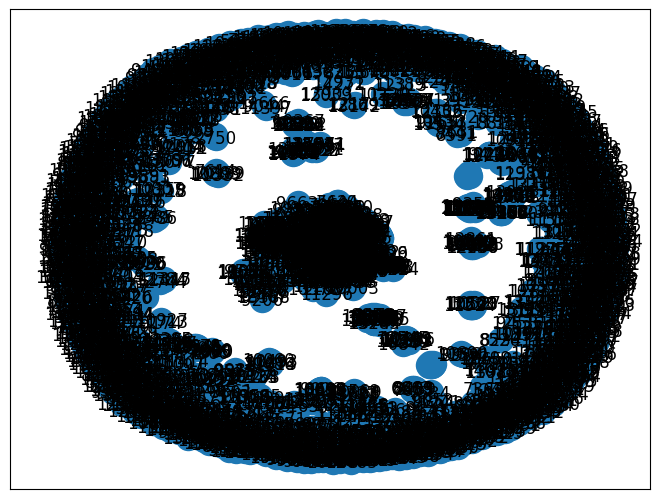

In [ ]:
# We draw the network. Slow since there are many nodes and edges
nx.draw(B_users, with_labels=True)

> We take the edges and create an edgelist, that will also give us information on the weight of the edges.The weight of the edges means how many same jobs have two people applied to. 

In [ ]:
edges_df = nx.to_pandas_edgelist(B_users)

In [ ]:
edges_df 

,source,target,weight
0,8211,7344,1
1,42,12672,1
2,42,10373,1
3,42,8645,2
4,42,6092,1
...,...,...,...
11388,7977,82807,1
11389,7977,146653,1
11390,7977,118014,1
11391,7977,150207,1


In [ ]:
# Out of curiosity, how many different weights are they
edges_df['weight'].unique()

array([1, 2, 4, 3, 5], dtype=int64)

---
### 2.2. Category for recommendation and creation dictionary

> Now that we have the different users connected by the jobs they have looked at, we need to include information into the edges. To recommend jobs to the different users, we will use another column from the dataframe that can link two users. For this, lets take a look at the different columns

In [ ]:
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12370 entries, 0 to 12369
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Applicant.ID   12370 non-null  int64  
 1   Job.ID         12370 non-null  int64  
 2   Title          12370 non-null  object 
 3   Company        11790 non-null  object 
 4   City           12370 non-null  object 
 5   State.Name     12348 non-null  object 
 6   State.Code     12348 non-null  object 
 7   Industry       2199 non-null   object 
 8   View.Start     12370 non-null  object 
 9   View.End       10575 non-null  object 
 10  View.Duration  10575 non-null  float64
 11  Created.At     12370 non-null  object 
 12  Updated.At     12370 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 1.2+ MB


> The interesting columns are company, city, state name, and industry. Industry would be the most interesting one, but there are many null values (2199 out of 12370 non null). We are also missing information on company and state, so we will use the City

In [ ]:
# Create dataframe with applicantID and city
data_connection=pd.DataFrame(data, 
                             columns=('Applicant.ID', 'City'))
#instead of views we use data, the dataframe without the duplicates
data_connection

,Applicant.ID,City
0,10000,Newark
1,10000,Garden City
2,10001,Bellingham
3,10002,Simpsonville
4,10002,Greenville
...,...,...
12365,9997,San Francisco
12366,9997,San Francisco
12367,9997,Oakland
12368,9997,San Francisco


> The problem we have is that there are multiple cities connected to one single user. Lets create a column in which all cities are included inside a cell

In [ ]:
data_connection['Cities'] = data_connection.groupby(['Applicant.ID'])['City'].transform(lambda x: ','.join(x))
data_connection=data_connection.drop(columns=('City'))
data_connection=data_connection.drop_duplicates()
data_connection

,Applicant.ID,Cities
0,10000,"Newark,Garden City"
2,10001,Bellingham
3,10002,"Simpsonville,Greenville"
5,10003,Annandale
6,10004,Cleveland
...,...,...
12343,9993,Frisco
12344,9994,"Janesville,Janesville,Janesville,Janesville,Ja..."
12349,9995,"San Francisco,San Francisco,San Francisco,San ..."
12358,9996,"Bethesda,Wheaton,McLean"


> I would need the values to be inside an array, for further utilization

In [ ]:
data_connection['Cities']=data_connection.Cities.str.split(pat=',')
data_connection=data_connection.sort_values(by='Applicant.ID')
data_connection

,Applicant.ID,Cities
8878,42,"[San Francisco, San Francisco, San Francisco, ..."
11672,96,"[San Francisco, San Francisco, Burlingame]"
8721,153,"[Roseville, Citrus Heights, Citrus Heights, Ci..."
8986,601,"[Bay Area, San Francisco, Dededo, Palo Alto, P..."
8747,1877,[Sunnyvale]
...,...,...
8711,14546,"[los angeles, los angeles, los angeles]"
8714,14547,"[New York, New York]"
8716,14549,[New York]
8717,14552,[New York]


> Now we have one row for each applicant with some cities assigned. This information has to be entered into each node, but inside nodes there only can be dictionaries. So we tranform this dataframe into a dictionary.

In [ ]:
# Set tha applicant.ID as index
data_connection=data_connection.set_index('Applicant.ID')
data_connection

,Cities
Applicant.ID,
42,"[San Francisco, San Francisco, San Francisco, ..."
96,"[San Francisco, San Francisco, Burlingame]"
153,"[Roseville, Citrus Heights, Citrus Heights, Ci..."
601,"[Bay Area, San Francisco, Dededo, Palo Alto, P..."
1877,[Sunnyvale]
...,...
14546,"[los angeles, los angeles, los angeles]"
14547,"[New York, New York]"
14549,[New York]


In [ ]:
# Transform into dictionary
dic= data_connection.to_dict(orient='index')
# dic

> Once we have the dictionary, for each user we include the information of cities in each node of the graph

In [ ]:
nx.set_node_attributes(B_users,dic)

> Once the attributes are inside the nodes we can create the proposal of jobs for an specific user

---
### 2.3. Recommnedation

> Here we are going to create a function whose input is the applicant id and the network, and output a list of possible jobs that he couls/should applu

In [ ]:
def recommened_jobs(user, network):
    neighbors=[]
    for x in network.neighbors(user):
        neighbors.append(x)
    # Now lets choose the jobs to recommend
    cities= network.nodes()[user]['Cities']
    res=data[data['Applicant.ID'].isin(neighbors) 
             & (data['City'].isin(cities))]
    res=res.drop_duplicates(subset=['Job.ID'])
    res=res.drop(columns=['Applicant.ID','View.Start',
                          'View.End','View.Duration',
                          'Created.At','Updated.At'])
    return res

In [ ]:
# Lets see the jobs that a user has viewed
views.loc[views['Applicant.ID']==601]

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
8986,601,63054,Retail Sales Consultant @ AT&T Retail,AT&T Retail,Bay Area,California,CA,NaN,2015-01-14 11:55:06 UTC,2015-01-14 11:56:38 UTC,92.0,2015-01-14 11:55:06 UTC,2015-01-14 11:55:06 UTC
8987,601,82917,"Associate Manager @ Tumi, Inc","Tumi, Inc",San Francisco,California,CA,NaN,2015-01-14 12:04:03 UTC,2015-01-14 12:04:56 UTC,52.0,2015-01-14 12:04:03 UTC,2015-01-14 12:04:03 UTC
8988,601,98700,Toys R Us Express Seasonal Store Supervisor @ ...,"Toys ""R"" Us, Inc",Dededo,NaN,NaN,NaN,2015-01-16 11:30:19 UTC,2015-01-19 04:12:17 UTC,232917.0,2015-01-16 11:30:19 UTC,2015-01-16 11:30:19 UTC
8989,601,111,Server @ Tacolicious,Tacolicious,Palo Alto,California,CA,Food and Beverages,2014-11-29 02:10:56 UTC,NaN,NaN,2014-11-29 02:10:56 UTC,2014-11-29 02:10:56 UTC
8990,601,111,Server @ Tacolicious,Tacolicious,Palo Alto,California,CA,Food and Beverages,2014-11-29 08:02:43 UTC,NaN,NaN,2014-11-29 08:02:43 UTC,2014-11-29 08:02:43 UTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9056,601,188567,Evening and Weekends Men's Clothing Sales Prof...,Bloomingdales,New York,New York,NY,NaN,2015-02-05 09:38:15 UTC,2015-02-05 09:38:30 UTC,14.0,2015-02-05 09:38:15 UTC,2015-02-05 09:38:15 UTC
9057,601,214346,Delivery Team Couriers (Drivers and Bikers) @ ...,OrderAhead,Manhattan,New York,NY,Transportation,2015-02-08 08:10:25 UTC,2015-02-15 14:13:53 UTC,626607.0,2015-02-08 08:10:25 UTC,2015-02-08 08:10:25 UTC
9058,601,153197,Driving Partner @ Uber,Uber,San Francisco,California,CA,Transportation,2015-01-30 09:20:18 UTC,2015-01-30 09:20:37 UTC,18.0,2015-01-30 09:20:18 UTC,2015-01-30 09:20:18 UTC
9059,601,188567,Evening and Weekends Men's Clothing Sales Prof...,Bloomingdales,New York,New York,NY,NaN,2015-02-03 13:16:31 UTC,2015-02-05 09:38:11 UTC,159699.0,2015-02-03 13:16:31 UTC,2015-02-03 13:16:31 UTC


In [ ]:
# Now our function will recommend this person jobs around Bay Area, New York, Palo Alto, etc
recommened_jobs(601,B_users)

,Job.ID,Title,Company,City,State.Name,State.Code,Industry,title_clean,cluster
700,153197,Driving Partner @ Uber,Uber,San Francisco,California,CA,Transportation,partner,20
702,95272,LCSW / CNA / RN / LPT @ Concentric Healthcare ...,Concentric Healthcare Solutions,San Francisco,California,CA,NaN,lcsw cna rn lpt,1
751,82917,"Associate Manager @ Tumi, Inc","Tumi, Inc",San Francisco,California,CA,NaN,associate manager,2
1092,118388,Package Handler - Part-Time @ UPS,UPS,San Francisco,California,CA,NaN,package handler,6
1094,63054,Retail Sales Consultant @ AT&T Retail,AT&T Retail,Bay Area,California,CA,NaN,retail sale consultant,16
...,...,...,...,...,...,...,...,...,...
12298,84,Driver @ Onigilly,Onigilly,San Francisco,California,CA,Food and Beverages,driver,12
12299,85024,Social Media Evaluator - Freelance @ Appen,Appen,San Francisco,California,CA,NaN,social medium evaluator freelance,1
12314,98700,Toys R Us Express Seasonal Store Supervisor @ ...,"Toys ""R"" Us, Inc",Dededo,NaN,NaN,NaN,toy r express seasonal store supervisor,1
12315,62499,Mechanic @ United States Army,United States Army,Agana,NaN,NaN,NaN,mechanic,1


> The recommender function works as expected. This can be used with any user